### Описание тестовых данных и задание

**Таблица лицевых счетов и услуг:**
1. ИД дома - идентификатор дома
2. ИД подъезда - идентификатор подъезда в доме (может быть несколько подъездов в 1 доме)
3. ИД квартиры - идентификатор квартиры в подъезде (может быть несколько квартир в 1 подъезде)
4. Лицевой счет (ЛС) - номер лицевого счета в квартире (может быть несколько в 1 квартире)
5. Услуга - услуга периодического обслуживания (может быть несколько услуг на 1 ЛС)
6. Тариф - ставка тарифа в месяц по услуге, действующая на момент выгрузки данных.
7. Статус услуги - название статуса услуги.
  * Одновременно на одной квартире может быть только одна базовая услуга ТО МКД, ТО СВОД или ТО ДВЕРЬ в статусе! = Завершена.
  * Остальные услуги дополнительные и могут быть на одном ЛС с базовой или дополнительном ЛС на квартире.
8. Дата начала услуги - дата начала действия услуги на ЛС.
Если на одном ЛС есть несколько базовых услуг (ТО МКД, ТО СВОД или ТО ДВЕРЬ), то ранее действующая должна быть в статусе Завершена.
**Таблица платежей, поступивших за период с 01.01.2018 по 13.10.2021:**
1. ЛС - номер лицевого счета
2. Сумма платежа - сумма платежа, поступившего на ЛС
3. Дата загрузки - дата загрузки платежа в БД
4. Источник платежа - способ ввода платежа БД. Возможны возвраты платежей со знаком "-" и списания со знаком "+"
5. Способ оплаты - источник платежа (название платежной системы или оплат в офисе)
6. Комментарий к платежу - существенная информация по платежу

**Задания:**
1. Выполнить проверку данных в таблице лицевых счетов. Кратко описать суть проверки, результат проверки и предпринятый или предлагаемый способ устранение дефекта данных (если обнаружены артефакты).
2. Рассчитать для каждого ЛС сумму всех поступивших платежей с учетом возвратов, но исключая списания.
3. Рассчитать для каждого ЛС плановую выручку с учетом дат начала услуг на ЛС и ставки тарифа
4. Рассчитать для каждого ЛС сальдо: плановая выручка (п. 3) минус сумма платежей (из п. 2).
5. Рассчитать для каждой квартиры частоту платежей и количество оплаченных тарифов а календарный год.
6. Предложите другие метрики для анализа платежной дисциплины абонентов за услуги.
7. Визуализируйте метрики:
  * в календарной динамике
  * с акцентом на обнаруженные отклонения/аномалии



###Задание 1
Выполнить проверку данных в таблице лицевых счетов. Кратко описать суть проверки, результат проверки и предпринятый или предлагаемый способ устранение дефекта данных (если обнаружены артефакты).

Для начала скачаем данныем и посмотрим на них.

In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (10, 6)

In [459]:
url_payments = 'https://docs.google.com/spreadsheets/d/1vvVA4VL9jiVS2L1IEr0xih93Q3vfX-_w/edit?usp=drive_link&ouid=100738510060926451894&rtpof=true&sd=true'
url_personal_accounts = 'https://docs.google.com/spreadsheets/d/14AKvEs6ETPPwWfJSrhh4l1Z8V5scMymT/edit?usp=drive_link&ouid=100738510060926451894&rtpof=true&sd=true'
path_payments = 'https://drive.google.com/uc?export=download&id='+url_payments.split('/')[-2]
path_personal_accounts = 'https://drive.google.com/uc?export=download&id='+url_personal_accounts.split('/')[-2]

In [460]:
payments = pd.read_excel(path_payments)
personal_accounts = pd.read_excel(path_personal_accounts)

Посмотрим на данные в таблице ```payments```

In [461]:
payments.head()

,ЛС,Сумма платежа,Дата загрузки,Источник платежа,способ оплаты,Комментарий к платежу
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN
1,1,14.4,2018-10-17,Ввод из реестра,Сбербанк России,NaN
2,1,14.4,2019-01-21,Ввод из реестра,КС банк,NaN
3,1,32.4,2020-12-11,Ввод из реестра,КС банк,NaN
4,1,56.4,2018-02-09,Ввод из реестра,КС банк,NaN


Переименуем колонки для удобства работы.

In [462]:
payments.columns = ['account_id', 'payment',
                    'date', 'source',
                    'payment_method', 'comment']

In [463]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356846 entries, 0 to 356845
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   account_id      356846 non-null  int64         
 1   payment         356846 non-null  float64       
 2   date            356846 non-null  datetime64[ns]
 3   source          356846 non-null  object        
 4   payment_method  356846 non-null  object        
 5   comment         5876 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 16.3+ MB


In [464]:
payments.describe()

,account_id,payment
count,356846.000000,356846.000000
mean,22754.473936,24.977960
std,13770.609762,22.258772
min,1.000000,-492.477000
25%,10905.000000,5.400000
50%,21940.000000,15.000000
75%,33953.000000,43.400000
max,49151.000000,570.477000


Перейдем к таблице ```personal_accounts```.

In [465]:
personal_accounts.head()

,ИД дома,ИД подъезда,ИД квартиры,Лицевой счет (ЛС),Услуга,Ставка тарифа,Статус услуги,Дата начала услуги
0,100,1624,43036,43036,ТО МКД,5.2,Активна,2008-01-23
1,100,1624,43037,43037,ТО МКД,5.4,Активна,2008-01-23
2,100,1624,43038,43038,ТО МКД,5.2,Активна,2008-01-23
3,100,1624,43039,43039,ТО МКД,5.2,Активна,2008-01-23
4,100,1624,43040,43040,ТО МКД,5.2,Активна,2008-01-23


Так же переименуем.

In [466]:
personal_accounts.columns = ['home_id', 'entrance_id',
                             'apartment_id', 'account_id',
                             'service', 'tariff_rate',
                             'service_status', 'service_start_date']

In [467]:
personal_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49543 entries, 0 to 49542
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   home_id             49543 non-null  int64         
 1   entrance_id         49543 non-null  int64         
 2   apartment_id        49543 non-null  int64         
 3   account_id          49543 non-null  int64         
 4   service             49543 non-null  object        
 5   tariff_rate         49316 non-null  float64       
 6   service_status      49543 non-null  object        
 7   service_start_date  49543 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


In [468]:
personal_accounts.describe()

,home_id,entrance_id,apartment_id,account_id,tariff_rate
count,49543.000000,49543.000000,49543.000000,49543.000000,49316.000000
mean,3388.933432,769.268817,23054.720162,23141.157701,5.224343
std,1776.316133,562.511739,14149.534471,14187.140567,0.243436
min,100.000000,1.000000,1.000000,1.000000,4.000000
25%,1633.000000,281.000000,10649.500000,10694.000000,5.200000
50%,4742.000000,626.000000,22337.000000,22436.000000,5.200000
75%,4914.000000,1241.000000,34949.000000,35048.500000,5.400000
max,5219.000000,1885.000000,49556.000000,49153.000000,9.700000


In [469]:
personal_accounts.describe(include='object')

,service,service_status
count,49543,49543
unique,6,7
top,ТО МКД,Активна
freq,42318,39065


In [470]:
personal_accounts.describe(datetime_is_numeric=True)

,home_id,entrance_id,apartment_id,account_id,tariff_rate,service_start_date
count,49543.000000,49543.000000,49543.000000,49543.000000,49316.000000,49543
mean,3388.933432,769.268817,23054.720162,23141.157701,5.224343,2009-09-09 03:26:34.178794240
min,100.000000,1.000000,1.000000,1.000000,4.000000,2006-08-30 00:00:00
25%,1633.000000,281.000000,10649.500000,10694.000000,5.200000,2007-01-12 00:00:00
50%,4742.000000,626.000000,22337.000000,22436.000000,5.200000,2007-06-22 00:00:00
75%,4914.000000,1241.000000,34949.000000,35048.500000,5.400000,2010-09-11 00:00:00
max,5219.000000,1885.000000,49556.000000,49153.000000,9.700000,2021-11-01 00:00:00
std,1776.316133,562.511739,14149.534471,14187.140567,0.243436,NaN


In [471]:
personal_accounts['service_status'].value_counts()

Активна               39065
Завершена              5976
Не предоставляется     2979
Отказ                  1451
Приостановлена           70
Не обслуживается          1
Будет активна             1
Name: service_status, dtype: int64

In [472]:
personal_accounts['service'].value_counts()

ТО МКД                     42318
ТО СВОД                     4360
ТО Дверь                    1834
ВБ                           808
Рассрочка за Монтаж ВБ       206
Рассрочка за Апгрейд ВБ       17
Name: service, dtype: int64

Мы видим что в колонке ```tariff_rate``` есть пропущенные значения, взглянем на них.



In [473]:
personal_accounts['tariff_rate'].value_counts()

5.4    22350
5.2    18954
5.0     4845
4.5     2409
4.3      287
4.0      273
4.7       68
5.6       66
4.8       63
9.7        1
Name: tariff_rate, dtype: int64

In [474]:
personal_accounts['tariff_rate'].isna().sum()

227

In [475]:
personal_accounts[personal_accounts['tariff_rate'].isna()].head()

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date
54,105,785,25746,25746,Рассрочка за Монтаж ВБ,NaN,Активна,2016-07-28
530,137,949,28855,28855,Рассрочка за Монтаж ВБ,NaN,Активна,2018-01-31
763,150,804,26104,26104,Рассрочка за Монтаж ВБ,NaN,Активна,2018-01-26
765,150,804,26105,26105,Рассрочка за Монтаж ВБ,NaN,Активна,2018-02-02
807,151,818,26403,26403,Рассрочка за Монтаж ВБ,NaN,Активна,2018-07-31


In [476]:
(personal_accounts[personal_accounts['tariff_rate'].isna()]['service']
                    .value_counts())

Рассрочка за Монтаж ВБ     206
Рассрочка за Апгрейд ВБ     17
ТО МКД                       2
ТО Дверь                     2
Name: service, dtype: int64

Больше всего пропущенных значений дополнительные услуги, в частности рассрочка. Так же есть 4 значения в базовых услугах. Количество пропущеных значений минимально, поэтому можно их удалить.

In [477]:
print(personal_accounts.shape[0])
personal_accounts.dropna(inplace=True)
print(personal_accounts.shape[0])

49543
49316


Посмотрим на даты начала предоставления услуг.

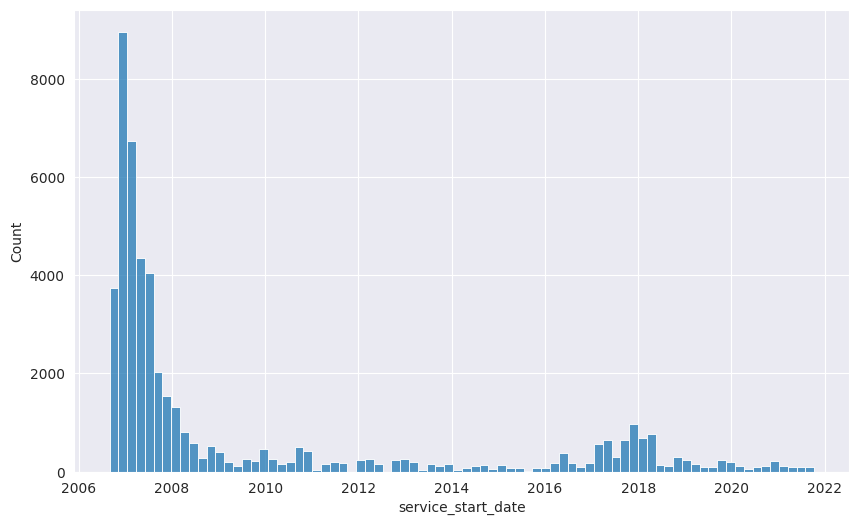

In [478]:
sns.histplot(personal_accounts['service_start_date']);

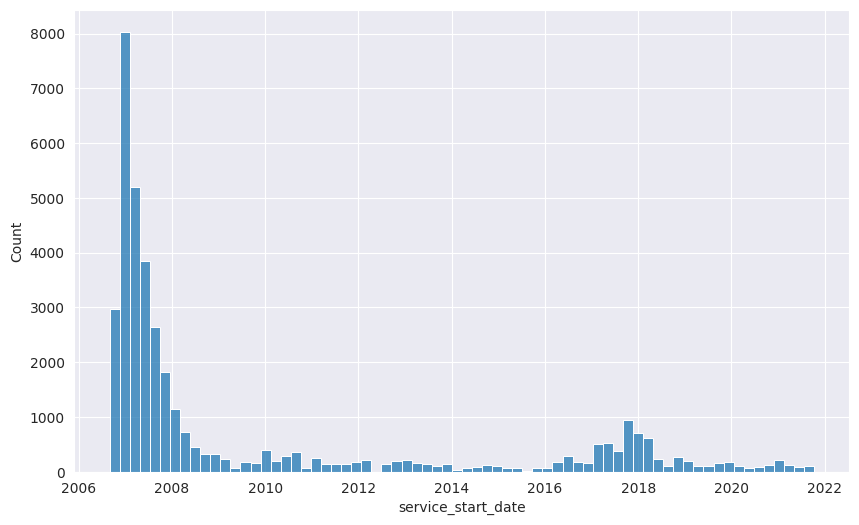

In [479]:
sns.histplot(personal_accounts[personal_accounts['service_status'] == 'Активна']
            ['service_start_date']);

In [480]:
print(personal_accounts['service_start_date'].min(),
      personal_accounts['service_start_date'].max(), sep='\n')

2006-08-30 00:00:00
2021-10-11 00:00:00


Данные в таблице с лицевыми счетами предоставлены за период с ```30.08.2006``` по ```11.10.2021```, а в таблице с платежами данные за период с ```01.01.2018``` по ```13.10.2021```. Так же можно заметить самое большое количество новых активных услуг в ```2007``` году и небольшой всплеск в ```2017-2018```.

Посмотрим на данные с ИД дома, подъезда, квартиры.

In [481]:
(personal_accounts.groupby('home_id')['entrance_id']
                  .nunique().sort_values(ascending=False))

home_id
4927    9
2809    8
4914    8
5079    8
4980    8
       ..
3752    1
3749    1
3697    1
3639    1
5219    1
Name: entrance_id, Length: 877, dtype: int64

Количество подъездов в доме не вызывает вопросов.

In [482]:
(personal_accounts.groupby('home_id')['apartment_id']
                  .nunique().sort_values(ascending=False))

home_id
2809    271
3398    215
1358    211
233     210
5165    205
       ... 
5086      8
594       8
5009      8
592       7
2978      7
Name: apartment_id, Length: 877, dtype: int64

Посмотрим на дом с самым большим количеством квартир.

In [483]:
(personal_accounts[personal_accounts['home_id'] == 2809]
                  .groupby('entrance_id')['apartment_id'].nunique())

entrance_id
350     33
391     34
471     34
513     34
590     33
723     32
993     36
1452    35
Name: apartment_id, dtype: int64

Количество квартир в доме в норме.

In [484]:
(personal_accounts.groupby('home_id')['account_id']
                  .nunique().sort_values(ascending=False))

home_id
2809    271
3398    215
1358    211
233     210
5165    205
       ... 
5086      8
594       8
5009      8
592       7
2978      7
Name: account_id, Length: 877, dtype: int64

In [485]:
(personal_accounts.groupby('home_id')['account_id']
                  .count().sort_values(ascending=False))

home_id
5165    439
1358    437
233     433
2200    369
5169    368
       ... 
5009      8
5201      8
5086      8
3697      8
2978      7
Name: account_id, Length: 877, dtype: int64

В некоторых домах количество уникальных аккаунтов в 2 раза меньше общего количества. Это говорит о том что на один лицевой счет предоставляется(предоставлялось) несколько услуг.

In [486]:
(personal_accounts[personal_accounts['service_status'] == 'Активна']
                  .groupby('home_id')['account_id']
                  .nunique().sort_values(ascending=False))

home_id
2809    244
1358    195
233     193
4811    192
3398    188
       ... 
5099      6
592       6
3697      6
2978      6
594       6
Name: account_id, Length: 877, dtype: int64

Количество уникальных аккаунтов с активным статусом услуги не сильно отличается от общего колличества уникальных аккаунтов.

Посмотрим сколько лицевых счетов приходится на квартиру.

In [487]:
(personal_accounts.groupby('apartment_id')['account_id']
                  .count().sort_values(ascending=False).head(10))

apartment_id
7016     6
25564    6
43413    5
45451    5
4533     5
4380     5
17234    5
46774    5
46158    4
374      4
Name: account_id, dtype: int64

Возьмем квартиру с наибольшим количеством лицевых счетов.

In [488]:
personal_accounts[personal_accounts['apartment_id'] == 7016].head()

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date
15772,2186,180,7016,7016,ТО МКД,5.4,Завершена,2006-11-25
15773,2186,180,7016,7016,ТО СВОД,5.4,Завершена,2018-01-02
15774,2186,180,7016,7016,ТО Дверь,5.4,Завершена,2018-01-04
15775,2186,180,7016,7016,ТО Дверь,5.4,Завершена,2018-01-01
15776,2186,180,7016,7016,ТО Дверь,5.0,Активна,2019-06-07


Все в порядке: Только 1 статус ```"Активна"``` на 1 лицевой счет.

Добавим колонку ```service_status_flag``` для бинарного разделения статуса сервиса. Статус ```"Активна"``` будет ```1```,
все остальные статусы ```0```.

In [489]:
personal_accounts['service_status_flag'] = (personal_accounts['service_status']
                                            .apply(lambda x: 1
                                                   if x == 'Активна' else 0))

In [490]:
personal_accounts.head()

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date,service_status_flag
0,100,1624,43036,43036,ТО МКД,5.2,Активна,2008-01-23,1
1,100,1624,43037,43037,ТО МКД,5.4,Активна,2008-01-23,1
2,100,1624,43038,43038,ТО МКД,5.2,Активна,2008-01-23,1
3,100,1624,43039,43039,ТО МКД,5.2,Активна,2008-01-23,1
4,100,1624,43040,43040,ТО МКД,5.2,Активна,2008-01-23,1


Окончательно проверим что у нас для каждого аккаунта существует только **1 активный статус** для **базовой** услуги. Отберем базовые услуги с активным статусом, сравним количество уникальных аккаунтов и общее число аккаунтов.

In [491]:
base_servise_active = (personal_accounts
                       .query("service in ('ТО МКД', 'ТО Дверь', 'ТО СВОД')\
                       and service_status == 'Активна'"))

In [492]:
(base_servise_active['account_id'].nunique()
== base_servise_active['account_id'].count())

True

Ошибок в статусе нет.

In [493]:
(personal_accounts.groupby(['home_id', 'entrance_id'],
                           as_index=False)['apartment_id']
                  .nunique().sort_values('apartment_id',
                                         ascending=False))

,home_id,entrance_id,apartment_id
1790,5197,1813,108
286,944,1318,107
521,1911,313,94
412,1377,1094,90
1094,4854,445,89
...,...,...,...
493,1814,1802,7
804,3696,1745,7
1260,4924,1299,7
681,2978,1313,7


Отберем пользователей только с активными услугами и проставим количество активных услуг для каждого аккаунта.

In [494]:
active_status = (personal_accounts[personal_accounts['service_status'] \
                                   == "Активна"]
                 .sort_values(['account_id', 'service_start_date']))

In [495]:
active_status['num_active_service'] = (active_status
                                       .groupby('account_id')['service_status']
                                       .transform('count'))

In [496]:
active_status[active_status['num_active_service'] > 1].head()

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date,service_status_flag,num_active_service
24133,4733,2,48,48,ТО МКД,5.4,Активна,2006-08-31,1,2
24134,4733,2,48,48,ВБ,5.0,Активна,2012-11-26,1,2
24156,4733,2,72,72,ТО МКД,5.2,Активна,2006-08-31,1,2
24157,4733,2,72,72,ВБ,4.0,Активна,2018-07-11,1,2
24190,4733,2,106,106,ТО МКД,5.2,Активна,2006-08-31,1,2


Посмотрим почему произошел всплеск активации услуг по годам и по каким именно услугам.

In [497]:
(active_status[active_status['service_start_date'] > '2017']['service']
              .value_counts())

ТО СВОД     3286
ТО Дверь    1170
ТО МКД      1118
ВБ           321
Name: service, dtype: int64

In [498]:
(active_status[active_status['service_start_date'] < '2017']['service']
              .value_counts())

ТО МКД     32009
ТО СВОД      567
ВБ           373
Name: service, dtype: int64

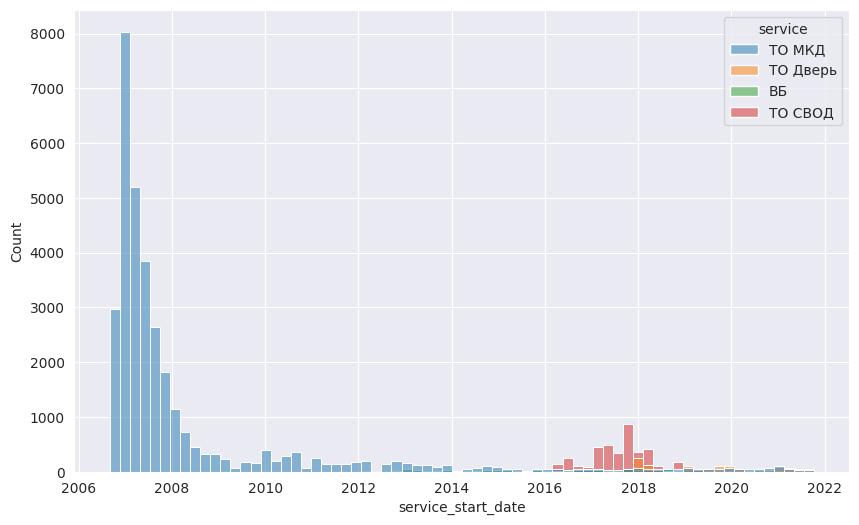

In [499]:
sns.histplot(data=active_status, x='service_start_date', hue='service');

По графику видно что основная услуга компании ТО МКД, но в 2017 году стали появляться новые услуги такие как ТО СВОД, ТО Дверь. Возможно это связано с переходом некоторых домов с ТО МКД на системы видеобезопасности и ограничения доступа с 2017 года.

### Задание 2
Рассчитать для каждого ЛС сумму всех поступивших платежей с учетом возвратов, но исключая списания.

Посмотрим на таблицу с платежами выясним какие есть источники платежа, возвраты и списания.

In [500]:
payments.head()

,account_id,payment,date,source,payment_method,comment
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN
1,1,14.4,2018-10-17,Ввод из реестра,Сбербанк России,NaN
2,1,14.4,2019-01-21,Ввод из реестра,КС банк,NaN
3,1,32.4,2020-12-11,Ввод из реестра,КС банк,NaN
4,1,56.4,2018-02-09,Ввод из реестра,КС банк,NaN


In [501]:
payments['source'].value_counts()

Ввод из реестра     342350
Ручной ввод          10166
Авто. списание        2992
Ручное списание        698
Возврат                244
Возврат списания       208
Сторно минус           186
Сторно плюс              2
Name: source, dtype: int64

In [502]:
payments[payments['payment'] < 0].head()

,account_id,payment,date,source,payment_method,comment
6,2,-167.5,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
7,2,-144.0,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
8,2,-108.0,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
9,2,-108.0,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи с сайта
10,2,-71.7,2020-03-31,Возврат,Сайт ЦС,ошибочные платежи


In [503]:
payments.query('source in ("Ручное списание", "Авто. списание")').head()

,account_id,payment,date,source,payment_method,comment
354,25,66.60,2019-12-31,Авто. списание,Офис,В соответствии с приказом № <..>СПИСАНИЕ
516,49,85.70,2019-12-31,Авто. списание,Офис,В соответствии с приказом № <..>ПРОДАЖА
822,84,58.80,2019-12-31,Авто. списание,Офис,В соответствии с приказом № <..>ПРОДАЖА
846,88,83.40,2019-12-31,Авто. списание,Офис,В соответствии с приказом № <..>ПРОДАЖА
1098,119,6.67,2019-12-31,Авто. списание,Офис,В соответствии с приказом № <..>ПРОДАЖА


Нам нужно изподсчетов суммы платежей исключить 2 вида списаний и учесть возвраты.

In [504]:
payments_subframe = (payments
                     .query('source not in ("Ручное списание", \
                     "Авто. списание")'))

Финальная таблица с суммой платежей исключая списания.

In [505]:
payments_per_acc = (payments_subframe
                    .groupby('account_id', as_index=False)['payment'].sum())
payments_per_acc

,account_id,payment
0,1,182.40
1,2,236.40
2,3,230.40
3,4,236.40
4,5,222.90
...,...,...
39626,49146,62.40
39627,49148,31.20
39628,49149,31.20
39629,49150,25.81


### Задание 3
Рассчитать для каждого ЛС плановую выручку с учетом дат начала услуг на ЛС и ставки тарифа.

В таблице лицевых счетов даты начала предоставления услуг представлены в более широком диапозоне чем в таблице платежей, для дальнейших расчетов нужно сделать срез по таблице ЛС. Так как у нас есть только дата начала действия услуги и нет даты окончания услуги, мы не сможем рассчитать сколько месяцев предоставлялась завершенная услуга. Поэтому будем считать только по активным услугам.

Добавим колонки с минимальной и максимальной датой из таблицы платежей.

In [506]:
min_date = payments['date'].min()
max_date = payments['date'].max()

In [507]:
print(min_date,
      max_date, sep='\n')

2018-01-04 00:00:00
2021-10-13 00:00:00


In [508]:
active_status.loc[active_status['service_start_date'] > '2018-01-04',
                  'min_date'] = active_status['service_start_date']

In [509]:
active_status.loc[active_status['service_start_date'] < '2018-01-04',
                  'min_date'] = min_date

In [510]:
active_status['max_date'] = max_date
active_status.head()

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date,service_status_flag,num_active_service,min_date,max_date
13171,1662,1,1,1,ТО МКД,5.2,Активна,2021-03-01,1,1,2021-03-01,2021-10-13
13173,1662,1,2,2,ТО МКД,5.2,Активна,2007-10-01,1,1,2018-01-04,2021-10-13
13174,1662,1,3,3,ТО МКД,5.4,Активна,2006-09-02,1,1,2018-01-04,2021-10-13
13175,1662,1,4,4,ТО МКД,5.2,Активна,2006-09-02,1,1,2018-01-04,2021-10-13
13176,1662,1,5,5,ТО МКД,5.4,Активна,2006-09-02,1,1,2018-01-04,2021-10-13


Создадим колонку с длительностью предоставления услуги в месяцах.

In [511]:
active_status['dur_of_service'] = ((active_status['max_date']
                                    - active_status['min_date'])
                                    / np.timedelta64(1, 'M')).astype(int)

In [512]:
active_status.drop(columns=('service_status_flag'), inplace=True)
active_status.head()

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date,num_active_service,min_date,max_date,dur_of_service
13171,1662,1,1,1,ТО МКД,5.2,Активна,2021-03-01,1,2021-03-01,2021-10-13,7
13173,1662,1,2,2,ТО МКД,5.2,Активна,2007-10-01,1,2018-01-04,2021-10-13,45
13174,1662,1,3,3,ТО МКД,5.4,Активна,2006-09-02,1,2018-01-04,2021-10-13,45
13175,1662,1,4,4,ТО МКД,5.2,Активна,2006-09-02,1,2018-01-04,2021-10-13,45
13176,1662,1,5,5,ТО МКД,5.4,Активна,2006-09-02,1,2018-01-04,2021-10-13,45


In [513]:
active_status['revenue'] = (active_status['tariff_rate']
                            * active_status['dur_of_service'])

Подсчитаем выручку по всем пользователям.

In [514]:
revenue_df = (active_status
              .groupby('account_id', as_index=False)['revenue'].sum())
revenue_df

,account_id,revenue
0,1,36.4
1,2,234.0
2,3,243.0
3,4,234.0
4,5,243.0
...,...,...
38145,49149,48.6
38146,49150,43.2
38147,49151,37.8
38148,49152,10.8


### Задание 4
Рассчитать для каждого ЛС сальдо: плановая выручка (п. 3) минус сумма платежей (из п. 2).

Для расчета сальдо нам нужно соединить 2 таблицы и подсчитать сам показатель.

In [515]:
net_profit = revenue_df.merge(payments_per_acc, how='inner', on='account_id')

In [516]:
net_profit['net'] = net_profit['revenue'] - net_profit['payment']
net_profit

,account_id,revenue,payment,net
0,1,36.4,182.40,-146.00
1,2,234.0,236.40,-2.40
2,3,243.0,230.40,12.60
3,4,234.0,236.40,-2.40
4,5,243.0,222.90,20.10
...,...,...,...,...
37998,49146,46.8,62.40,-15.60
37999,49148,48.6,31.20,17.40
38000,49149,48.6,31.20,17.40
38001,49150,43.2,25.81,17.39


### Задание 5
Рассчитать для каждой квартиры частоту платежей и количество оплаченных тарифов а календарный год.

Объединим 2 таблицы для подсчета частоты платежей и количество оплаченных тарифов за год.

In [517]:
payments_per_appart = (payments
                       .merge(active_status[['apartment_id',
                                             'tariff_rate',
                                             'account_id']],
                              how='left', on='account_id'))
payments_per_appart.head()

,account_id,payment,date,source,payment_method,comment,apartment_id,tariff_rate
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN,1.0,5.2
1,1,14.4,2018-10-17,Ввод из реестра,Сбербанк России,NaN,1.0,5.2
2,1,14.4,2019-01-21,Ввод из реестра,КС банк,NaN,1.0,5.2
3,1,32.4,2020-12-11,Ввод из реестра,КС банк,NaN,1.0,5.2
4,1,56.4,2018-02-09,Ввод из реестра,КС банк,NaN,1.0,5.2


In [518]:
payments_per_appart['year'] = payments_per_appart['date'].dt.year

In [519]:
payments_per_year = (payments_per_appart
                     .groupby(['apartment_id', 'year', 'tariff_rate'],
                              as_index=False)
                     .agg(num_of_payments=('payment', 'count'),
                          sum_of_payments=('payment', 'sum')))

In [520]:
payments_per_year['tarrif_paid_per_year'] = (
    payments_per_year['sum_of_payments'] / payments_per_year['tariff_rate'])

In [521]:
personal_accounts[personal_accounts['apartment_id'] == 1]

,home_id,entrance_id,apartment_id,account_id,service,tariff_rate,service_status,service_start_date,service_status_flag
13170,1662,1,1,1,ТО МКД,5.4,Завершена,2006-09-02,0
13171,1662,1,1,1,ТО МКД,5.2,Активна,2021-03-01,1
13172,1662,1,1,1,ТО Дверь,5.0,Завершена,2020-01-01,0


Таблица с расчетом частоты платежей и количеством оплаченных тарифов за календарный год.

In [522]:
payments_per_year

,apartment_id,year,tariff_rate,num_of_payments,sum_of_payments,tarrif_paid_per_year
0,1.0,2018,5.2,2,70.8,13.615385
1,1.0,2019,5.2,2,19.2,3.692308
2,1.0,2020,5.2,2,92.4,17.769231
3,2.0,2018,5.2,1,56.4,10.846154
4,2.0,2019,5.2,1,57.6,11.076923
...,...,...,...,...,...,...
135077,49547.0,2021,5.4,1,31.2,5.777778
135078,49548.0,2021,5.4,9,46.8,8.666667
135079,49550.0,2021,5.2,1,62.4,12.000000
135080,49552.0,2021,5.4,1,31.2,5.777778


### Задание 6
Предложите другие метрики для анализа платежной дисциплины абонентов за услуги.


* Средний платеж:

Вычислить среднюю сумму платежа, чтобы понять типичный размер платежа от абонента.

* Структура платежей:

Разбить общую сумму платежей по видам услуг. Это может помочь выявить, какие услуги чаще всего оплачиваются.

* Сезонность платежей:

Есть ли сезонные колебания в платежах. Например, могут быть периоды с повышенной или пониженной активностью оплаты.

Посмотрим на средний платеж по месяцам и годам.

In [523]:
payments['year_month'] = payments['date'].dt.to_period('M')

In [524]:
payments_per_month = (payments.groupby(['year_month'])
                      .agg(mean_payment=('payment', 'mean')))

In [525]:
payments_per_month

,mean_payment
year_month,
2018-01,39.712707
2018-02,34.487214
2018-03,33.102182
2018-04,22.022249
2018-05,17.523907
2018-06,16.904217
2018-07,16.367899
2018-08,14.701314
2018-09,14.792248


Разобъем платежы по услугам.

In [526]:
payments_per_service = payments.merge(active_status[['account_id',
                                                     'service',
                                                     'tariff_rate']],
                              how='left', on='account_id')

In [527]:
payments_per_service_agg = (payments_per_service
                        .groupby(['year_month', 'service'])
                        .agg(count_per_service=('payment', 'count'),
                             mean_per_service=('payment', 'mean')))

In [528]:
payments_per_service_agg

count_per_service  mean_per_service
year_month service                                      
2018-01    ВБ                      268         59.673910
           ТО Дверь                228         33.273184
           ТО МКД                14764         39.747779
           ТО СВОД                2049         41.446070
2018-02    ВБ                      159         55.213208
...                                ...               ...
2021-09    ТО СВОД                 650         16.446358
2021-10    ВБ                       18         34.860111
           ТО Дверь                 20         12.902500
           ТО МКД                 1043         19.932547
           ТО СВОД                 161         19.204304

[184 rows x 2 columns]

### Задание 7
Визуализируйте метрики:
* в календарной динамике
* с акцентом на обнаруженные отклонения/аномалии

Средний платеж в разрезе год-месяц.

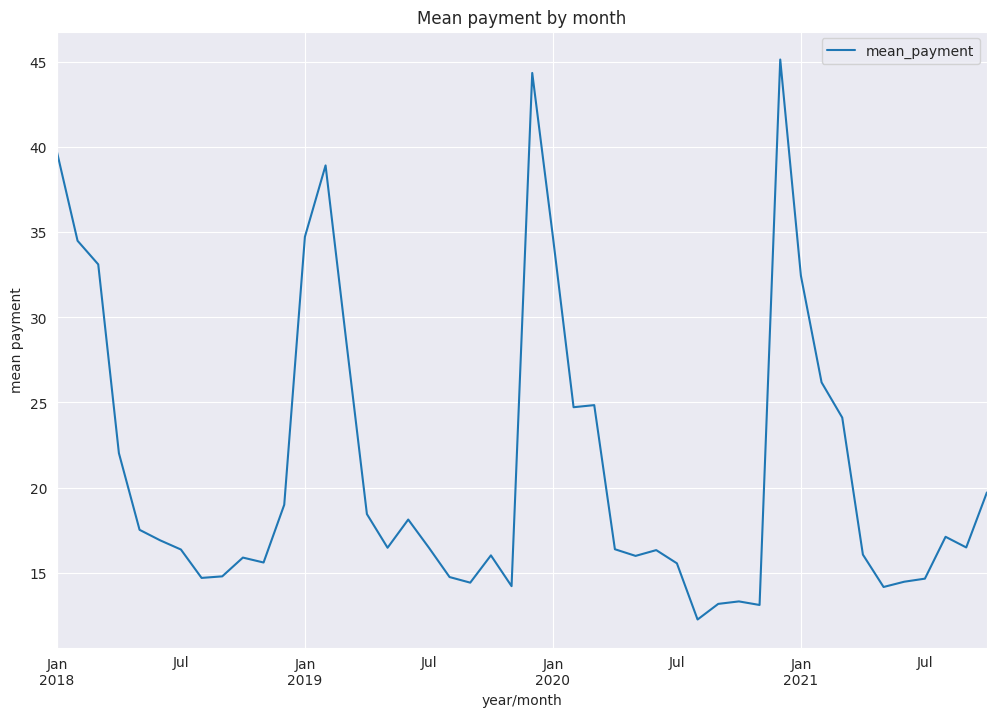

In [529]:
payments_per_month.plot(figsize=(12, 8), title='Mean payment by month',
                        xlabel='year/month', ylabel='mean payment');

Средний платеж по услугам.

In [530]:
payments_per_service_agg.reset_index(inplace=True)

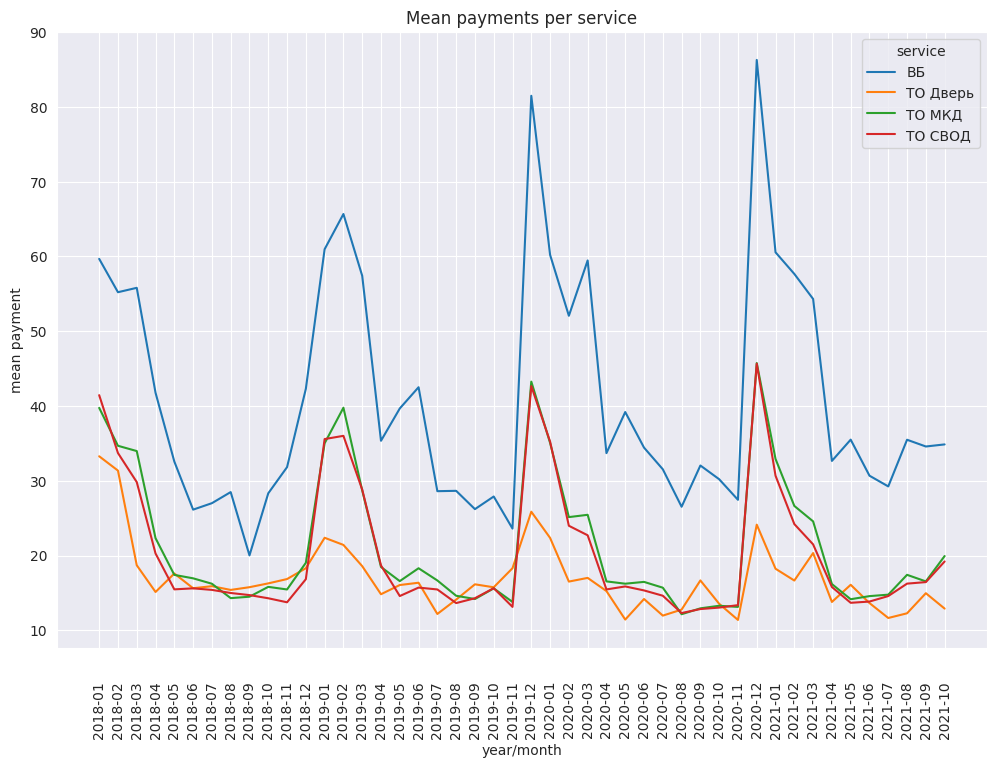

In [531]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=payments_per_service_agg,
                  x=payments_per_service_agg['year_month'].astype(str),
                  y='mean_per_service', hue='service')
ax.set_title('Mean payments per service')
ax.set_xlabel('year/month')
ax.set_ylabel('mean payment')
ax.tick_params(axis='x', length=20, width=1, labelrotation=90)

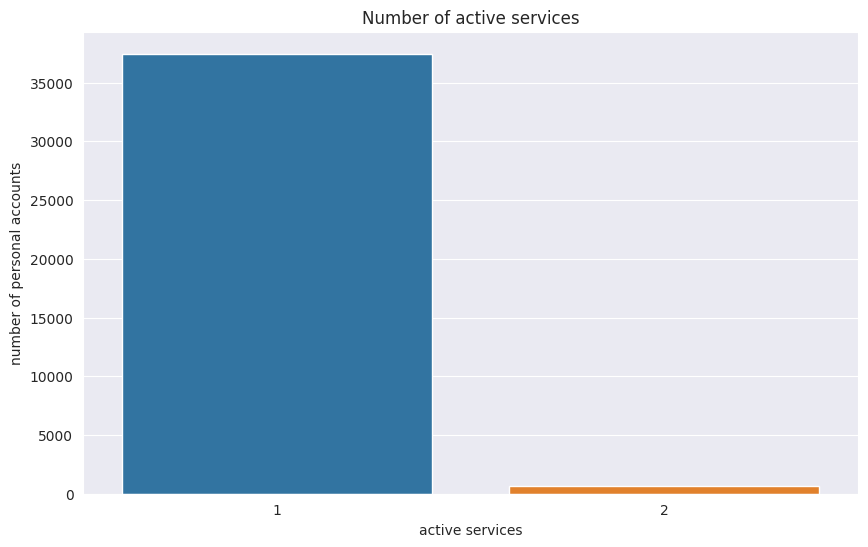

In [532]:
plt.figure(figsize=(10, 6))
ax = (sns.barplot(active_status
                  .groupby('num_active_service', as_index=False)['account_id']
                  .nunique(), x='num_active_service', y='account_id'))
ax.set_title('Number of active services')
ax.set_xlabel('active services')
ax.set_ylabel('number of personal accounts');

По графикам видна ярко выраженная сезонность платежей по тарифам. Самый большие платежи за услугу `ВБ`, но его доля в сервисах мала. Средний платеж по услугам `ТО МКД` и `ТО СВОД` примерно одинаковы. Всплеск появления услуги `ТО СВОД` и большое количество статусов "Завершена" у услуги `ТО МКД` в 2017-2019 обусловлено переходом на системы видеобезопасности и ограничения доступа.

Малое количество лицевых счетов у которых активно 2 услуги.

In [533]:
payments['source'].value_counts()

Ввод из реестра     342350
Ручной ввод          10166
Авто. списание        2992
Ручное списание        698
Возврат                244
Возврат списания       208
Сторно минус           186
Сторно плюс              2
Name: source, dtype: int64

In [534]:
payments['payment_method'].value_counts()

КС банк                   250982
Сбербанк России            86470
Офис                        7683
Сбербанк ЦИФРАЛ-СЕРВИС      5935
Сайт ЦС                     2232
Выписки                     1759
Почта                        940
Актив банк                   498
Россельхозбанк               175
Элекснет                     141
Почта Рузаевка                31
Name: payment_method, dtype: int64

In [535]:
payments['comment'].value_counts()

Потерянные платежи во время реорганизации                 1520
В соответствии с приказом № <..>ПРОДАЖА                   1468
В соответствии с приказом № <..>СПИСАНИЕ                  1180
В соответствии с приказом № <..>СПИСАНИЕ ПРОДАННЫХ БДЗ     344
смена собственника квартиры\                               249
                                                          ... 
нулевой чек                                                  1
не работал МКД\смена собственника                            1
Отсутствие абонента; не проживал                             1
Не работал МКД; был в ремонте монитор                        1
прочее\собственник один на 2 кв. будет платить за 169        1
Name: comment, Length: 451, dtype: int64

In [536]:
payments.query('comment == "Потерянные платежи во время реорганизации"')['date'].value_counts()

2021-09-06    1520
Name: date, dtype: int64

In [537]:
payments.query('comment == "В соответствии с приказом № <..>ПРОДАЖА"').describe()

,account_id,payment
count,1468.000000,1468.000000
mean,24973.758856,56.772360
std,13989.426194,28.657892
min,49.000000,0.010000
25%,13037.750000,27.000000
50%,24352.000000,58.900000
75%,37178.500000,83.044750
max,48405.000000,159.720000


In [538]:
net_profit.describe()

,account_id,revenue,payment,net
count,38003.000000,38003.000000,38003.000000,38003.000000
mean,23403.816725,233.661582,225.422371,8.239211
std,13862.975859,40.558592,44.808313,37.742850
min,1.000000,0.000000,0.000000,-871.300000
25%,11424.500000,234.000000,222.600000,-3.600000
50%,23173.000000,234.000000,236.400000,-2.400000
75%,34936.500000,243.000000,237.000000,19.200000
max,49151.000000,468.000000,1105.300000,326.400000


In [539]:
payments_extended = (payments
                       .merge(active_status[['apartment_id',
                                             'tariff_rate',
                                             'account_id', 'dur_of_service']],
                              how='inner', on='account_id'))
payments_extended.head()

,account_id,payment,date,source,payment_method,comment,year_month,apartment_id,tariff_rate,dur_of_service
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN,2019-04,1,5.2,7
1,1,14.4,2018-10-17,Ввод из реестра,Сбербанк России,NaN,2018-10,1,5.2,7
2,1,14.4,2019-01-21,Ввод из реестра,КС банк,NaN,2019-01,1,5.2,7
3,1,32.4,2020-12-11,Ввод из реестра,КС банк,NaN,2020-12,1,5.2,7
4,1,56.4,2018-02-09,Ввод из реестра,КС банк,NaN,2018-02,1,5.2,7


In [540]:
payments_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354047 entries, 0 to 354046
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   account_id      354047 non-null  int64         
 1   payment         354047 non-null  float64       
 2   date            354047 non-null  datetime64[ns]
 3   source          354047 non-null  object        
 4   payment_method  354047 non-null  object        
 5   comment         3260 non-null    object        
 6   year_month      354047 non-null  period[M]     
 7   apartment_id    354047 non-null  int64         
 8   tariff_rate     354047 non-null  float64       
 9   dur_of_service  354047 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3), period[M](1)
memory usage: 29.7+ MB


In [541]:
payments_extended.groupby('source')['payment'].agg(['count', 'mean', 'sum'])

,count,mean,sum
source,,,
Авто. списание,517,59.110961,30560.367
Ввод из реестра,342770,24.832089,8511695.179
Возврат,224,-40.803585,-9140.003
Возврат списания,170,-49.326012,-8385.422
Ручное списание,608,45.488640,27657.093
Ручной ввод,9582,35.612333,341237.372
Сторно минус,174,25.899483,4506.510
Сторно плюс,2,-23.400000,-46.800


In [542]:
payments_extended['payment_per_account'] = (payments_per_service
                                            .groupby('account_id')['payment']
                                            .transform('sum'))
payments_extended['planned_revenue'] = (payments_extended['dur_of_service'] \
                                        * payments_extended['tariff_rate'])

In [543]:
payments_extended.head()

,account_id,payment,date,source,payment_method,comment,year_month,apartment_id,tariff_rate,dur_of_service,payment_per_account,planned_revenue
0,1,4.8,2019-04-16,Ручной ввод,Офис,NaN,2019-04,1,5.2,7,182.4,36.4
1,1,14.4,2018-10-17,Ввод из реестра,Сбербанк России,NaN,2018-10,1,5.2,7,182.4,36.4
2,1,14.4,2019-01-21,Ввод из реестра,КС банк,NaN,2019-01,1,5.2,7,182.4,36.4
3,1,32.4,2020-12-11,Ввод из реестра,КС банк,NaN,2020-12,1,5.2,7,182.4,36.4
4,1,56.4,2018-02-09,Ввод из реестра,КС банк,NaN,2018-02,1,5.2,7,182.4,36.4


In [544]:
payments_extended['net'] = (payments_extended['planned_revenue']
                            - payments_extended['payment_per_account'])

In [545]:
t = (payments_extended.groupby('payment_method', as_index=False)
    .agg(payment_count=('payment', 'count'),
         payment_sum=('payment', 'sum'))
    .sort_values('payment_sum', ascending=False))
t

,payment_method,payment_count,payment_sum
2,КС банк,250139,5917133.432
8,Сбербанк России,87170,2474943.483
3,Офис,4898,192487.678
9,Сбербанк ЦИФРАЛ-СЕРВИС,6012,104041.434
7,Сайт ЦС,2278,81740.457
1,Выписки,1793,57654.187
4,Почта,916,39246.436
0,Актив банк,506,20816.293
6,Россельхозбанк,169,5108.636
10,Элекснет,138,3920.000


Посмотрим каким способом оплаты чаще пользуются абоненты.

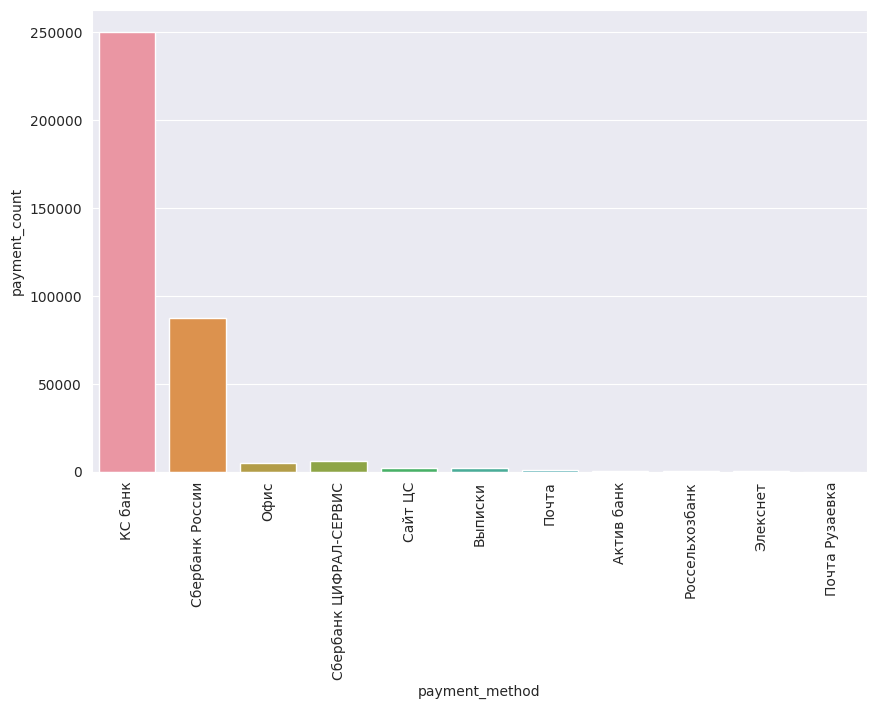

In [546]:
ax = sns.barplot(data=t, x='payment_method', y='payment_count')
ax.tick_params(axis='x', labelrotation=90)

In [547]:
t = (payments_extended.groupby('source')['payment']
     .agg(['count', 'sum', 'mean']).sort_values('count', ascending=False))
t

,count,sum,mean
source,,,
Ввод из реестра,342770,8511695.179,24.832089
Ручной ввод,9582,341237.372,35.612333
Ручное списание,608,27657.093,45.488640
Авто. списание,517,30560.367,59.110961
Возврат,224,-9140.003,-40.803585
Сторно минус,174,4506.510,25.899483
Возврат списания,170,-8385.422,-49.326012
Сторно плюс,2,-46.800,-23.400000


Визуализируем самый частый способ ввода платежа.

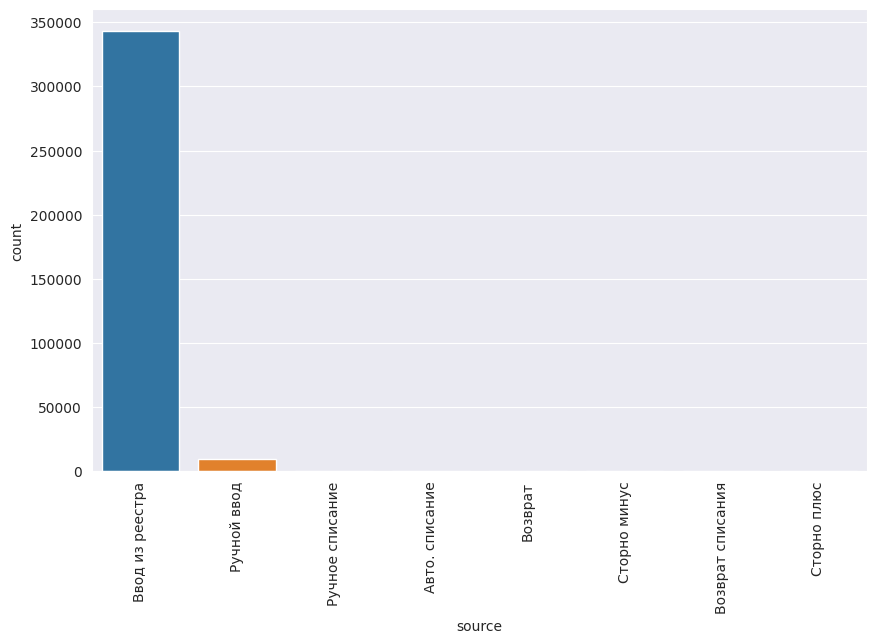

In [548]:
ax = sns.barplot(data=t.reset_index(), x='source', y='count')
ax.tick_params(axis='x', labelrotation=90)

In [549]:
t = (payments_extended.groupby('comment')['payment']
                  .agg(['count', 'sum', 'mean'])
                  .sort_values('count', ascending=False).reset_index())
t.head(10)

,comment,count,sum,mean
0,Потерянные платежи во время реорганизации,1535,20803.293,13.552634
1,В соответствии с приказом № <..>ПРОДАЖА,342,20994.872,61.388515
2,смена собственника квартиры\,236,13773.430,58.361992
3,В соответствии с приказом № <..>СПИСАНИЕ,122,7747.450,63.503689
4,не работал МКД\,118,4266.313,36.155195
5,Оплата ДЗ,94,-5668.351,-60.301606
6,спецпроект по работе с ДЗ\,65,4315.060,66.385538
7,ошибочные платежи с сайта,58,-2552.902,-44.015552
8,В соответствии с приказом № <..>СПИСАНИЕ ПРОДА...,53,1818.045,34.302736
9,Оплата ДЗ,37,-834.280,-22.548108


Какие суммы были зачислены и с какими комментариями.

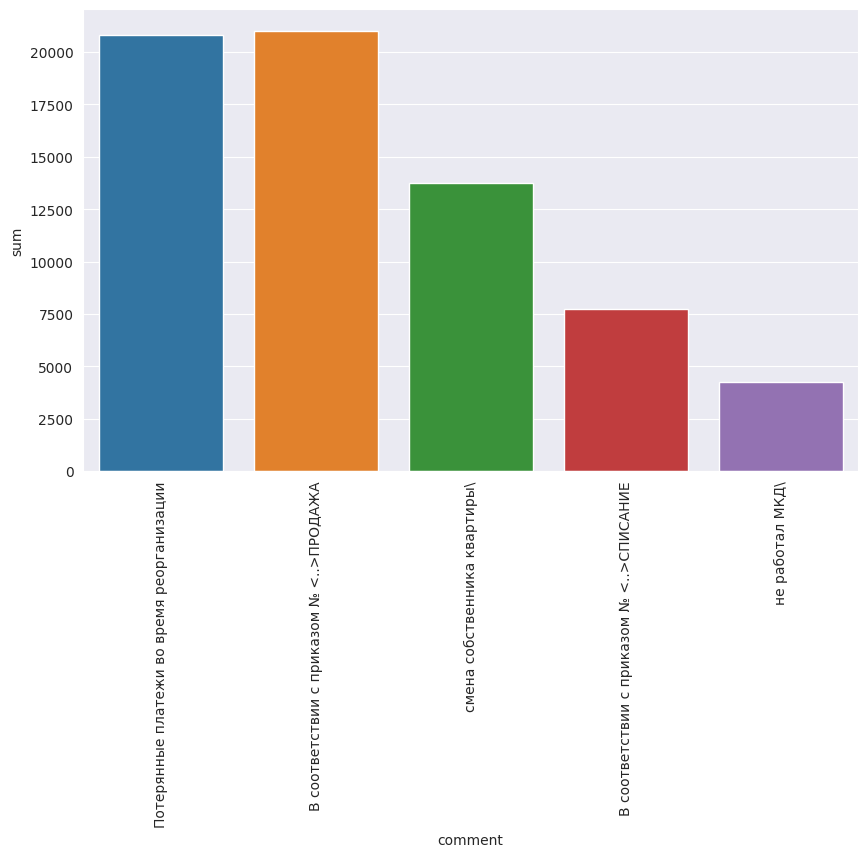

In [550]:
ax = sns.barplot(data=t.head(5), x='comment', y='sum')
ax.tick_params(axis='x', labelrotation=90)

Посмотрим на данные в разрезе зима/лето.

In [551]:
(payments_extended[payments_extended['date']
                   .dt.month.isin([10, 11, 12, 1, 2])]['comment']
 .value_counts())

В соответствии с приказом № <..>ПРОДАЖА                      342
В соответствии с приказом № <..>СПИСАНИЕ                     122
смена собственника квартиры\                                 118
В соответствии с приказом № <..>СПИСАНИЕ ПРОДАННЫХ БДЗ        53
не работал МКД\                                               51
                                                            ... 
не работал МКД\по согласованию с ДБЕ                           1
не работал МКД\по согласованию ДБЕ                             1
Не работал МКД; Монитор не работал, и ремонту не подлежит      1
Отсутствие абонента; Долг предидущих собственников             1
прочее\собственник один на 2 кв. будет платить за 169          1
Name: comment, Length: 186, dtype: int64

In [552]:
(payments_extended[payments_extended['date']
                   .dt.month.isin([5, 6, 7, 8, 9])]['comment']
 .value_counts())

Потерянные платежи во время реорганизации    1535
смена собственника квартиры\                   83
не работал МКД\                                52
спецпроект по работе с ДЗ\                     42
Оплата ДЗ                                      41
                                             ... 
не верно выбрала данные по платежу              1
прочее\оплата была 27.03.19                     1
своевременно не было реестра                    1
Не работал МКД; не работал мкд                  1
Новичков ОА                                     1
Name: comment, Length: 136, dtype: int64

In [553]:
(payments_extended[payments_extended['date']
                   .dt.month.isin([10, 11, 12, 1, 2])]['source'].value_counts())

Ввод из реестра     166958
Ручной ввод           4589
Авто. списание         517
Ручное списание        291
Возврат списания        77
Возврат                 59
Сторно минус            54
Сторно плюс              1
Name: source, dtype: int64

In [554]:
(payments_extended[payments_extended['date']
                   .dt.month.isin([5, 6, 7, 8, 9])]['source'].value_counts())

Ввод из реестра     111961
Ручной ввод           3036
Ручное списание        221
Возврат списания        76
Сторно минус            71
Возврат                 57
Name: source, dtype: int64

In [555]:
(payments_extended[payments_extended['date']
                   .dt.month.isin([5, 6, 7, 8, 9])]['date'].value_counts())

2021-09-06    1666
2021-07-27    1393
2020-07-27     953
2021-07-14     914
2021-05-24     874
              ... 
2021-06-26       1
2020-08-15       1
2020-06-28       1
2021-08-03       1
2020-05-05       1
Name: date, Length: 473, dtype: int64

In [556]:
(payments_extended[payments_extended['date']
                   .dt.month.isin([10, 11, 12, 1, 2])]['date'].value_counts())

2019-01-28    3039
2021-01-27    2391
2020-01-28    2212
2020-12-22    2196
2018-01-22    1875
              ... 
2020-11-22       1
2020-02-02       1
2020-11-21       1
2020-10-03       1
2020-01-26       1
Name: date, Length: 392, dtype: int64

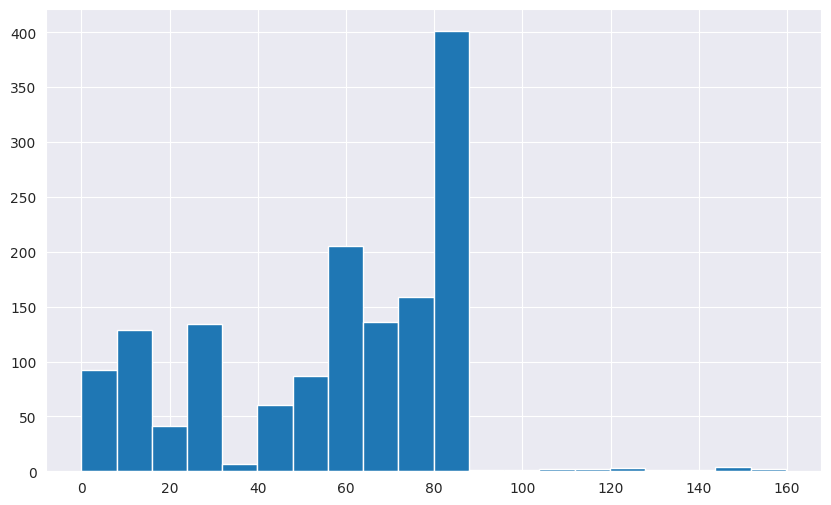

In [557]:
(payments.query('comment == "В соответствии с приказом № <..>ПРОДАЖА"')
['payment'].hist(bins=20));

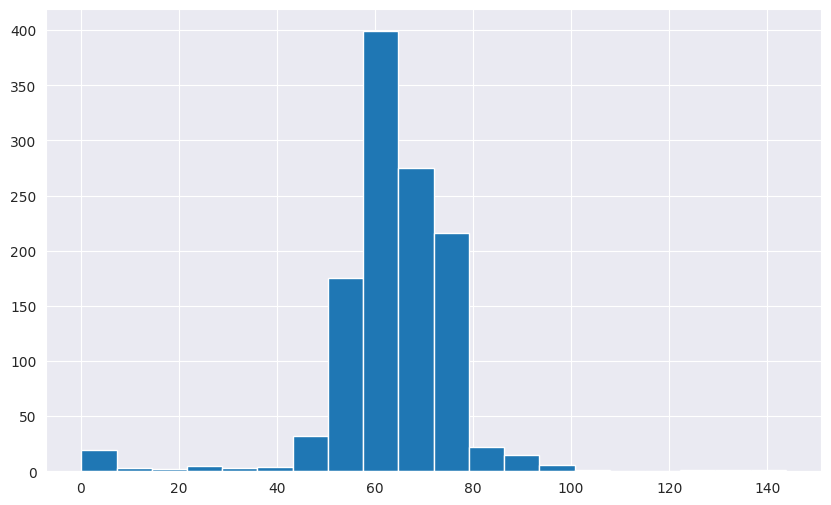

In [558]:
(payments.query('comment == "В соответствии с приказом № <..>СПИСАНИЕ"')
['payment'].hist(bins=20));

In [559]:
t = (payments_extended.groupby('source', as_index=False)
    .agg(payment_count=('payment', 'count'),
          payment_sum=('payment', 'sum'))
     .sort_values('payment_sum', ascending=False))
t

,source,payment_count,payment_sum
1,Ввод из реестра,342770,8511695.179
5,Ручной ввод,9582,341237.372
0,Авто. списание,517,30560.367
4,Ручное списание,608,27657.093
6,Сторно минус,174,4506.510
7,Сторно плюс,2,-46.800
3,Возврат списания,170,-8385.422
2,Возврат,224,-9140.003


Посмотрим на процент абонентов с задолжностью и с переплатами по услугам.

In [560]:
print(f'''Процент абонентов с переплатой по услугам: \
{(net_profit[net_profit['net'] < 0]
  .shape[0] / net_profit.shape[0] * 100):.2f}%
Процент абонентов с задолжностью по услугам: \
{(net_profit[net_profit['net'] > 0]
  .shape[0] / net_profit.shape[0] * 100):.2f}%
Процент абонентов с нулевым сальдо по услугам: \
{(net_profit[net_profit['net'] == 0]
  .shape[0] / net_profit.shape[0] * 100):.2f}%''')

Процент абонентов с переплатой по услугам: 56.20%
Процент абонентов с задолжностью по услугам: 43.48%
Процент абонентов с нулевым сальдо по услугам: 0.32%


In [561]:
debtors = net_profit[net_profit['net'] > 0]['account_id'].to_list()

In [562]:
personal_accounts['debtor_flag'] = (personal_accounts['account_id']
                                    .apply(lambda x: 1 if x in debtors else 0))

Самый большой процент должников за услугу ВБ, по услуге `ТО МКД` у 35% абонентов есть задолжность.

In [563]:
(personal_accounts.groupby('service')['debtor_flag']
 .agg(['count', 'sum', 'mean']))

,count,sum,mean
service,,,
ВБ,808,368,0.455446
ТО Дверь,1832,696,0.379913
ТО МКД,42316,16267,0.384417
ТО СВОД,4360,1522,0.349083


Рассмотрим дома и подъезды с самым большим числом должников.

In [564]:
(personal_accounts.groupby('home_id')['debtor_flag']
 .agg(['count', 'sum', 'mean']).sort_values('mean', ascending=False)).head()

,count,sum,mean
home_id,,,
1377,90,87,0.966667
5173,27,22,0.814815
5163,17,13,0.764706
3445,17,13,0.764706
5199,16,12,0.750000


In [565]:
(personal_accounts.groupby('entrance_id')['debtor_flag']
 .agg(['count', 'sum', 'mean']).sort_values('mean', ascending=False)).head()

,count,sum,mean
entrance_id,,,
1751,10,10,1.000000
1094,90,87,0.966667
1321,10,9,0.900000
1535,14,11,0.785714
1719,17,13,0.764706


### Основные выводы

Для улучшения платежной дисциплины абонентов возможны следующие шаги:

1. Увеличить количество способов оплаты. Предоставление абонентам разнообразных способов оплаты может сделать процесс оплаты более удобным, что, в свою очередь, может положительно сказаться на платежной дисциплине. На данный момент чаще всего используются 2 банка для оплаты `КС Банк` и `Сбербанк России`.

2. Автоматизация процессов. Эффективные автоматизированные системы для расчетов и обработки платежей, а также быстрая реакция на просрочки, могут значительно улучшить платежную дисциплину.

3. Обзор тарифов и услуг. По результатам анализа за услугу `ВБ` в среднем самый большой платеж, а процент должников по этой услуг достигает 45%. Возможно, пересмотр тарифов или предложение специальных акций может улучшить сбор платежей.

4. Образование и информирование абонентов. Предоставление абонентам информации о нововведениях, способах оплаты, их преимуществах и влиянии на платежную дисциплину может повысить осведомленность и уменьшить сопротивление. Работа с определенными домами и подъездами в которых процент абонентов с задолжностью достигает 97-100%.

5. Увеличить общую собираемость платежей:
  * Процент абонентов с переплатой по услугам: 56.20%
  * Процент абонентов с задолжностью по услугам: 43.48%
  * Процент абонентов с нулевым сальдо по услугам: 0.32%

6. Большое влияние на собираемость платежей оказывает списание денежных средств "В соответствии с приказом № <..>"